In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import ghmm
from scipy.stats import norm
from collections import Counter
from itertools import permutations
sys.path.append("..")
from script.static_SAX import znormalization,paa_transform,sax_transform

## A basic filtering function

In [2]:
def clean_outlier(column, threshold = 3):
    mean_column = column.mean()
    std_column = column.std()
    column[column > mean_column+threshold*std_column] = mean_column+3*std_column
    column[column < mean_column-threshold*std_column] = mean_column-3*std_column
    return column

# First studies of EEG signals 
In order to do some initial analysis of EEG signals we download the UCI [EEG Eye State Data Set](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State#). 

+ Dataset obtained from a continuous EEG measurement.
+ EEG technology used: `Emotiv EEG Neuroheadset`. 
+ Duration: 117 seconds. 
+ Last column: Eye state detected using a camera and added manually. (1: eye-closed, 0: eye-opened)
+ Values in chronological order (from the top to the bottom of the dataset)
+ Since the dataset contains 14980 points, the frequency of measures is of 128 points per second, which is close to 10 times the [frequency of Beta wave](http://emedicine.medscape.com/article/1139332-overview#a2). 

## Parameters of the SAX method

In [9]:
n_pieces = 1500
alphabet_sz = 30

## Load the dataset and apply the SAX method to get a vector of discrete emission as done previously

In [10]:
eeg = pd.read_csv("../data/EEG_Eye_State.arff",comment="@",header=None)
Y = eeg[eeg.columns[-1]]
X = eeg.drop(eeg.columns[-1],1)
X = X.apply(clean_outlier)
z_eeg = znormalization(X)
split_eeg = paa_transform(z_eeg, n_pieces)
sax_eeg = sax_transform(X, n_pieces, alphabet_sz, use_gaussian_assuption=True)
y_emissions = np.asarray(map(lambda xs: xs.max(axis = 0), np.array_split(Y, n_pieces)))

# First HMM model
## Computing the HMM probabilities
The function hereafter takes a sequence of emissions, a sequence of labels (the hidden states), the alphabet of emission, the alphabet of labels and the order of the markovian model and outputs the transition matrix between the Hidden States and the Emission Probability Vector for each hidden state. 

In [11]:
def compute_hmm_probabilities(emissions, labels, alphabet_emissions, alphabet_labels, hmm_order):
    hidden_states_transition_matrix = np.zeros((alphabet_labels.size,alphabet_labels.size))
    emission_counters = [Counter() for hidden_state in alphabet_labels]
    pairs_labels = zip(labels, labels[1:])
    tuples_emissions = zip(*(emissions[i:] for i in range(hmm_order)))
    current_hidden_state = pairs_labels[0][0]
    # fill counter with zeros
    tuples_emissions_alphabet = list(permutations(alphabet_emissions,hmm_order))
    for i,emission_counter in enumerate(emission_counters):
        for tuple_emission in tuples_emissions_alphabet:
            emission_counters[i][tuple_emission] = 0
    # fill counter with more values
    total_emissions = 0
    for i,label_pair in enumerate(pairs_labels):
        hidden_states_transition_matrix[label_pair[0],label_pair[1]] += 1
        if label_pair[0] != label_pair[1]:
            current_hidden_state = label_pair[1]
        else:
            emission_tuple = tuples_emissions[i]
            emission_counters[int(current_hidden_state)][emission_tuple] += 1
            total_emissions += 1
    # convert emisssion counters into emission vectors and normalize
    emission_vectors = [[emission_counters[int(hidden_state)][tuple_emission]*1./total_emissions for tuple_emission in tuples_emissions_alphabet] for hidden_state in alphabet_labels]
    hidden_states_transition_matrix *= 1./hidden_states_transition_matrix.sum()
    return emission_vectors,hidden_states_transition_matrix

# Emissions probabilities for different records
Emission probability of each symbol for eyes opened (0: blue) or closed (1: red)

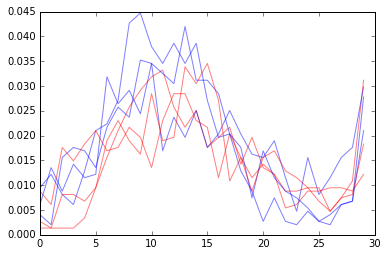

In [12]:
colors = ["b","r"]
for eeg_id in range(sax_eeg.shape[1])[0:3]:
#eeg_id = 2
    emissions = sax_eeg[:,eeg_id]
    labels = y_emissions
    alphabet_labels = np.unique(labels)
    alphabet_emissions = np.unique(emissions)
    alphabet = ghmm.IntegerRange(0,alphabet_emissions.size)
    hmm_order = 1
    emissions_probabilities,hidden_states_transition_matrix = compute_hmm_probabilities(emissions, labels, alphabet_emissions, alphabet_labels, hmm_order)
    for i,probability in enumerate(emissions_probabilities):
        plt.plot(range(len(probability)), probability,color = colors[i], alpha=0.5)

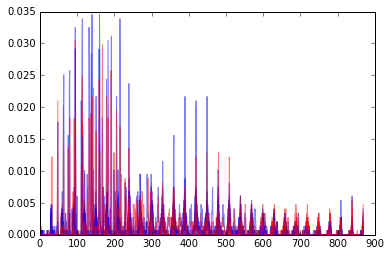

In [13]:
colors = ["b","r"]
for eeg_id in range(sax_eeg.shape[1]):
#eeg_id = 2
    emissions = sax_eeg[:,eeg_id]
    labels = y_emissions
    alphabet_labels = np.unique(labels)
    alphabet_emissions = np.unique(emissions)
    alphabet = ghmm.IntegerRange(0,alphabet_emissions.size)
    hmm_order = 2
    emissions_probabilities,hidden_states_transition_matrix = compute_hmm_probabilities(emissions, labels, alphabet_emissions, alphabet_labels, hmm_order)
    for i,probability in enumerate(emissions_probabilities):
        plt.plot(range(len(probability)), probability, "-", color = colors[i], alpha=0.5)

## Creating a HMM model using the ghmm library

In [14]:
eeg_id = 2
emissions = sax_eeg[:,eeg_id]
labels = y_emissions
alphabet_labels = np.unique(labels)
alphabet_emissions = np.unique(emissions)
alphabet = ghmm.IntegerRange(0,alphabet_emissions.size)
hmm_order = 1
emissions_probabilities,hidden_states_transition_matrix = compute_hmm_probabilities(emissions, labels, alphabet_emissions, alphabet_labels, hmm_order)
initial_conditions = [0.5,0.5]
m = ghmm.HMMFromMatrices(alphabet, 
                         ghmm.DiscreteDistribution(alphabet),
                         hidden_states_transition_matrix,
                         emissions_probabilities,
                         initial_conditions)
#m.baumWelch(ghmm.EmissionSequence(alphabet,list(sax_eeg[:,eeg_id])))

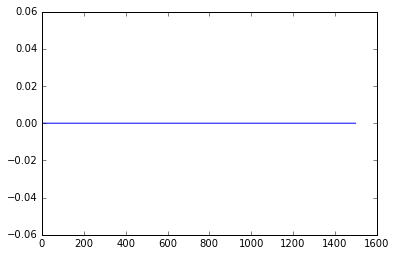

In [18]:
v = m.viterbi(ghmm.EmissionSequence(alphabet,list(sax_eeg[:,0])))[0]
plt.plot(range(len(v)),v)